# 2D Convolutional Neural Network - With Mean Feature


### Import Packages


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
)
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

# Check If GPU Enabled
Latest functioning version set as of October 6, 2024 according to https://www.tensorflow.org/install/source_windows is
- Python 3.10.11
- Tensorflow 2.10
- CUDA Toolkit 11.2
- CUDNN 8.1

In [2]:
# tf.debugging.set_log_device_placement(True) # For Verbose Output
print("Version: ", tf.__version__)


print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))


gpus = tf.config.list_physical_devices("GPU")
if gpus:

    print("TensorFlow is using GPU")
    for gpu in gpus:

        print(gpu.name)
else:

    print("TensorFlow is not using GPU")

Version:  2.10.0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU
/physical_device:GPU:0


# Pick Datasets to Train


In [3]:
lunar_train_dir = r"../../data/lunar/training/data/S12_GradeA"
num_of_events = len(
    [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
)
print("Number of events: ", num_of_events)
event = [i for i in range(5)]  # num_of_events

Number of events:  76


# Import Catalog


In [4]:
catalog_path = r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_path)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


# Get Filename and Anomaly Position

In [5]:
event_filename = [catalog["filename"][i] + r".csv" for i in event]
print("Event Filenames:", event_filename)

true_anomaly_time = [int(catalog["time_rel(sec)"][i]) for i in event]
print("Anomaly Positions in Each File:", true_anomaly_time)

Event Filenames: ['xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', 'xa.s12.00.mhz.1970-03-25HR00_evid00003.csv', 'xa.s12.00.mhz.1970-03-26HR00_evid00004.csv', 'xa.s12.00.mhz.1970-04-25HR00_evid00006.csv', 'xa.s12.00.mhz.1970-04-26HR00_evid00007.csv']
Anomaly Positions in Each File: [73500, 12720, 73020, 4440, 52140]


## Load Lunar Training Data


In [6]:
csv_files_path = r"../../data/lunar/training/data/S12_GradeA"
csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
print(csv_files)

['../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-03-25HR00_evid00003.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-03-26HR00_evid00004.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-04-25HR00_evid00006.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-04-26HR00_evid00007.csv']


# Get Length, Time, and Speed of Each Event
Load all .csv's into one dataframe. Additionally, take the standard normal value of the velocity values, *i.e.*
$$
    X_{standard} = \frac{X - \mu_X}{\sigma_X}.
$$

In [7]:
lens_array = []
time_arrays = []
data_arrays = []
for file in csv_files:
    df = pd.read_csv(file)

    lens_array.append(len(df))

    t = df["time_rel(sec)"].values
    time_arrays.append(t)

    X = df["velocity(m/s)"].values
    X_standard = (X - np.mean(X)) / np.std(X)
    data_arrays.append(X_standard)


time_array = np.concatenate(time_arrays)
time = pd.DataFrame(time_array, columns=["time_rel(sec)"])

data_array = np.concatenate(data_arrays)
seismic_data = pd.DataFrame(data_array, columns=["velocity(m/s)"])

## Data Preparation


In [8]:
X_standard = seismic_data["velocity(m/s)"].values
X_standard = X_standard.astype(np.float32)  # To save memory

## Create Window Sequences

In [9]:
windows_size = 16
batch_size = 500

# Create sequences for CNN
windows = []
features = []
for i in range(len(X_standard) - windows_size):
    windows.append(X_standard[i : i + windows_size])
    features.append(np.mean(X_standard[i : i + windows_size]))

windows = np.array(windows)
features = np.array(features)

In [10]:
print(windows.shape)
print(features.shape)

(2862047, 16)
(2862047,)


# Get True Anomaly Labels

Places a 0 in `y` for all the values before `anomaly_pos` and 1 for all the values after `anomaly_pos`. Creates a sigmoid labelling.

In [12]:
width = 20
freq = 6.625
sampling_freq = 1 / freq

y = np.zeros(len(X_standard[windows_size:]))

for anomaly_index in range(len(true_anomaly_time)):

    length = lens_array[anomaly_index]
    start = np.sum(lens_array[j] for j in range(anomaly_index))
    end = start + length
    print("Length of event:", length)
    print("[Start, End]:", "[", start, ",", end, "]")

    anomaly = true_anomaly_time[anomaly_index]
    print("Anomaly position:", anomaly)

    sigma = int(width)
    center = int(anomaly * freq)
    y[start + center - sigma : end] = 1
    print("Range of 1s:", "[", start + center - sigma, ",", start + center + sigma, "]")
    print("===================")

print("===================")
print("y shape:", y.shape)
print("Non-zero elements in y:", np.count_nonzero(y))

(572415,)
50


In [13]:
# Reshape your input data
windows = np.array(windows).reshape(-1, windows_size, 1)
print(windows.shape)
features = np.array(features).reshape(-1, 1, 1)
print(features.shape)

# Create the CNN model
model = models.Sequential()

# Input Layer
model.add(layers.Conv2D(windows_size, (3, 1), input_shape=(windows_size, 1, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

# Down Sampling Layers
model.add(layers.Conv2D(2 * windows_size, (3, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

model.add(layers.Conv2D(4 * windows_size, (3, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))  # 2.5 == 2 or 3

# Up Sampling Layers
model.add(layers.Conv2DTranspose(4 * windows_size, (2, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling2D(size=(2, 1)))

model.add(layers.Conv2DTranspose(2 * windows_size, (3, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling2D(size=(2, 1)))

# Output Layer
model.add(layers.Dense(1, activation="sigmoid"))
model.add(Flatten())


# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

(572399, 16, 1)
(572399, 1, 1)


# Train the Autoencoder using Real Data Only

In [14]:
# Train the autoencoder using normal data only
history = model.fit(windows, y, epochs=2, batch_size=batch_size)

Epoch 1/2
1145/1145 [==============================] - 10s 7ms/step - loss: 0.2524
Epoch 2/2
1145/1145 [==============================] - 8s 7ms/step - loss: 0.2107


# Plot the Accuracy Change Over Epochs

In [15]:
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

# Plot the Model Change Over Epochs

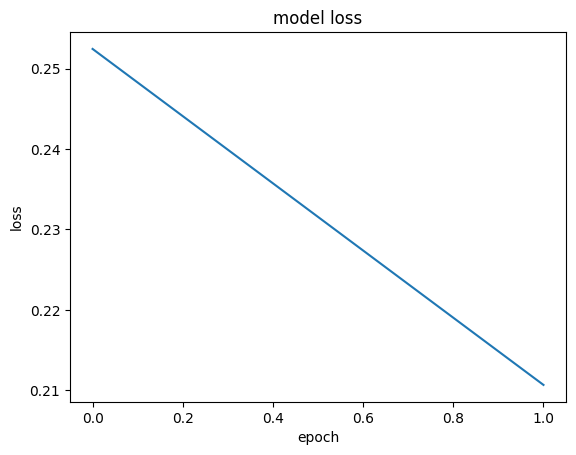

In [16]:
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Predict/Detect Anomalies
Calculate the reconstruction error on new data.

In [17]:
reconstructed = model.predict(windows)

17888/17888 [==============================] - 32s 2ms/step


In [18]:
print("Reconstructed Shape:", reconstructed.shape)
print("Windows Shape:", windows.shape)

[[0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]
 [0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]
 [0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]
 ...
 [0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]
 [0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]
 [0.05228971 0.05228971 0.05135477 ... 0.06317846 0.06377659 0.06377659]]
(572399, 16)
0.08826595
(572399, 16, 1)


# Calculate Mean Squared Error (MSE)

In [19]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print("MSE Shape:", mse.shape)

[0.00389744 0.00389525 0.00389282 ... 0.00387222 0.00387324 0.00387479]
186.64445
489366
58


# Set a Threshold for Anomaly Detection Based on the MSE Quantile Values

In [ ]:
high1 = np.quantile(np.abs(mse), 0.9999)
# high2 = np.quantile(np.abs(mse), 0.9951)
anomalies_label = [1 if i > high1 else 0 for i in mse]
print("Predicted Anomaly Position:", np.argmax(anomalies_label))
print(
    "Predicted Number of Anomalies:",
    np.count_nonzero(anomalies_label),
    "(depends directly on the quantile range)",
)

# Plot the Seismic Data and Scatterplot of the Predicted Data

58


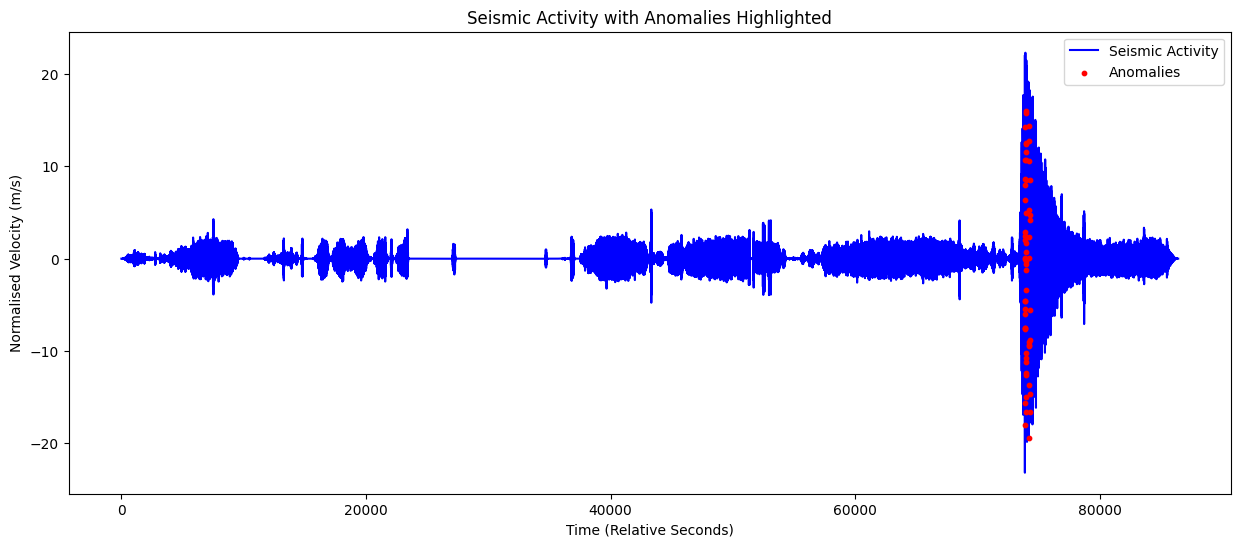

In [20]:
plt.figure(figsize=(15, 6))


plt.plot(
    time["time_rel(sec)"][:],
    X_standard,
    label="Seismic Activity",
    color="blue",
)


anomaly_indices = np.where(anomalies_label)[0]
plt.scatter(
    time["time_rel(sec)"][anomaly_indices + windows_size],
    X_standard[anomaly_indices + windows_size],
    color="red",
    label="Anomalies",
    marker="o",
    s=10,
    zorder=2,
)
print(len(anomaly_indices))

# arrival_line = plt.axvline(x=true_anomaly_time, c="red", label="Rel. Arrival")

plt.title("Seismic Activity with Anomalies Highlighted")
plt.xlabel("Time (Relative Seconds)")
plt.ylabel("Normalised Velocity (m/s)")
plt.legend()


plt.show()

# EXTRA: Confusion Matrix
Not really valid...

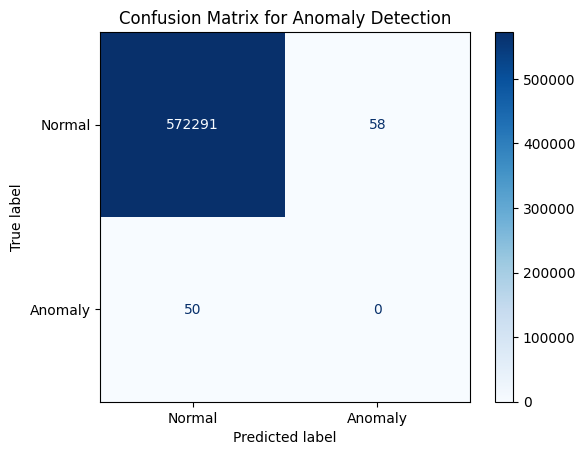

In [22]:
# y_pred = anomalies.astype(int)
conf_matrix = confusion_matrix(y, anomalies_label)

display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=["Normal", "Anomaly"]
)

display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Extract Model

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 1, 16)         64        
                                                                 
 batch_normalization (BatchN  (None, 14, 1, 16)        64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 1, 16)         0         
                                                                 
 dropout (Dropout)           (None, 14, 1, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 1, 32)         1568      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 1, 32)        128       
 hNormalization)                                        

In [25]:
model.save("cnn_2d_feature.keras")
model.save("cnn_2d_feature.h5")